In [2]:
# Special functions and optimizations
from typing import Callable, Union, Tuple
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.special import gamma, kv  # Bessel function and gamma function

import pandas as pd
import numpy as np

from GEMS_TCO import kernels

# Create a DataFrame with 3 columns: longitude, latitude, and time
data = {
    'longitude': np.random.uniform(-180, 180, 100),
    'latitude': np.random.uniform(-90, 90, 100),
    'time': np.random.uniform(90, 180, 100)
}

df = pd.DataFrame(data)
print(df)

df = df.to_numpy()

     longitude   latitude        time
0  -162.739222 -66.855172  162.561572
1    23.149920 -68.592035  163.859749
2    57.586419   2.939308  107.395748
3   -48.958565 -32.764690  139.382533
4    23.633379 -50.393177  169.071732
..         ...        ...         ...
95    3.971767  86.379759  138.160759
96  148.807748  18.654782  139.317940
97   34.457478  73.128408  178.765323
98 -150.279108  42.591624   96.138072
99  -94.618666  68.220036  161.239937

[100 rows x 3 columns]


In [3]:
smooth = 0.5
params = [20,8,8,0.5,0.5,0.1]

range_lon, range_lat = params[1], params[2]
sqrt_range_mat = np.diag([ 1/range_lon**0.5, 1/range_lat**0.5])
sqrt_range_mat = sqrt_range_mat


# Custom distance function for cdist
def custom_distance(u, v):
    d = np.dot(sqrt_range_mat, u[:2] - v[:2] ) # Distance between x1,x2 (2D)
    spatial_diff = np.linalg.norm(d)  # Distance between x1,x2 (2D)
    temporal_diff = np.abs(u[2] - v[2])           # Distance between y1 and y2
    return np.sqrt(spatial_diff**2 + temporal_diff**2)


def matern_cov_yx_test(params: Tuple[float,float,float,float,float,float], y: np.ndarray, x: np.ndarray) -> np.ndarray:

    sigmasq, range_lat, range_lon, advec, beta, nugget  = params
    # Validate inputs
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")
    # Extract values
    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 2]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 2] # hour

    spat_coord1 = np.stack((x1- advec*t1, y1 - advec*t1), axis=-1)
    spat_coord2 = np.stack((x2- advec*t2, y2 - advec*t2), axis=-1)

    coords1 = np.hstack ((spat_coord1, (beta * t1).reshape(-1,1) ))
    coords2 = np.hstack ((spat_coord2, (beta * t2).reshape(-1,1) ))



    distance = cdist(coords1,coords2, metric = custom_distance)

    # Initialize the covariance matrix with zeros
    out = distance
    
    # Compute the covariance for non-zero distances

    # Compute the covariance for non-zero distances
    non_zero_indices = distance != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = (sigmasq * (2**(1-smooth)) / gamma(smooth) *
                                (distance[non_zero_indices])**smooth *
                                kv(smooth, distance[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += np.eye(out.shape[0]) * nugget
    return out


b=matern_cov_yx_test(params,df,df)

def matern2(params: Tuple[float,float,float,float,float,float], y: np.ndarray, x: np.ndarray) -> np.ndarray:

    sigmasq, range_lat, range_lon, advec, beta, nugget  = params
    # Validate inputs
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")
    # Extract values
    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 2]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 2] # hour

    spat_coord1 = np.stack((x1- advec*t1, y1 - advec*t1), axis=-1)
    spat_coord2 = np.stack((x2- advec*t2, y2 - advec*t2), axis=-1)

    coords1 = np.hstack ((spat_coord1, (beta * t1).reshape(-1,1) ))
    coords2 = np.hstack ((spat_coord2, (beta * t2).reshape(-1,1) ))


    distance = cdist(coords1,coords2, metric = custom_distance)

    # Initialize the covariance matrix with zeros
    out = distance
    
    # Compute the covariance for non-zero distances

    # Compute the covariance for non-zero distances
    non_zero_indices = distance != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = sigmasq* np.exp(-distance[non_zero_indices])
    out[~non_zero_indices] = sigmasq
    

    # Add a small jitter term to the diagonal for numerical stability
    out += np.eye(out.shape[0]) * nugget
    return out
a = matern2(params,df,df)

print(b)

[[2.01000000e+01 7.15075181e-28 4.85338663e-42 ... 5.34210299e-35
  1.42106044e-26 8.59830901e-23]
 [7.15075181e-28 2.01000000e+01 2.80246504e-21 ... 2.65343008e-20
  1.18512030e-33 3.58559374e-27]
 [4.85338663e-42 2.80246504e-21 2.01000000e+01 ... 3.96357448e-18
  2.43068697e-31 6.91607634e-30]
 ...
 [5.34210299e-35 2.65343008e-20 3.96357448e-18 ... 2.01000000e+01
  7.02986742e-28 2.69252601e-18]
 [1.42106044e-26 1.18512030e-33 2.43068697e-31 ... 7.02986742e-28
  2.01000000e+01 4.86524109e-14]
 [8.59830901e-23 3.58559374e-27 6.91607634e-30 ... 2.69252601e-18
  4.86524109e-14 2.01000000e+01]]


In [4]:
np.sum(a-b)

-1.673371229044987e-15

In [5]:
import math

# Special functions and optimizations
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.optimize import minimize
from scipy.optimize import basinhopping, minimize
from scipy.stats import norm,uniform
from scipy.stats import t

def matern_cov(d,v):
    abs_d = np.abs(d)
    if abs_d ==0:
        return 1
    else:
        sigmasq = 2
        range = 1
        out = sigmasq * (2**(1-v))/math.gamma(v) * (abs_d/range)**(v)*kv(v, abs_d/range)        
        return out  
    
print(matern_cov(4,1.5))
d = 4
abs_d = np.abs(d)
sigmasq = 2
range_ = 1
out = sigmasq * (1+ abs_d/range_)* np.exp(-abs_d/range_)
print(out)


smooth=0.5

def matern_cov_yx_test1( params: Tuple[float, float, float, float, float,float], y: np.ndarray, x: np.ndarray) -> np.ndarray:
    sigmasq, range_space, range_tmp, sigmasq2, beta, nugget = params
    # Validate inputs
    if y is None or x is None:
        raise ValueError("Both y and x must be provided.")
    # Extract values
    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 2]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 2]  # hour

    spat_coord1 = np.stack((x1, y1), axis=-1)
    spat_coord2 = np.stack((x2, y2), axis=-1)
    temp_coord1 = t1.reshape(-1, 1)
    temp_coord2 = t2.reshape(-1, 1)

    spat_distance = cdist(spat_coord1, spat_coord2, metric='euclidean')
    temp_distance = cdist(temp_coord1, temp_coord2, metric='euclidean')

    # Initialize the covariance matrix with zeros
    out = np.zeros_like(spat_distance)

    non_zero_indices = spat_distance != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = (sigmasq * (2**(1 - smooth)) / gamma(smooth) *
                                (spat_distance[non_zero_indices] / range_space)**smooth *
                                kv(smooth, spat_distance[non_zero_indices]/range_space))
    out[~non_zero_indices] = sigmasq
    return out


0.18315638888734187
0.1831563888873418


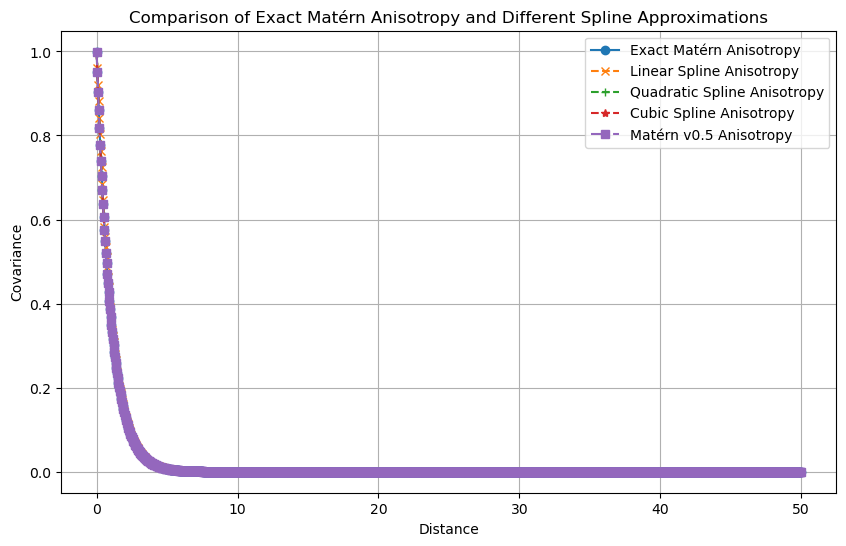

Mean distance between exact and linear spline anisotropy approximation: 0.0004215175019168083
Mean distance between exact and quadratic spline anisotropy approximation: 3.858123745193781e-05
Mean distance between exact and cubic spline anisotropy approximation: 9.985626917373366e-06
Mean distance between exact and Matérn v0.5 anisotropy approximation: 5.351458853487049e-18


In [24]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.special import kv, gamma
import matplotlib.pyplot as plt

def exact_matern_cov_anisotropy(params, distances):
    sigmasq, range_lat, range_lon, smooth = params
    matern_values = sigmasq * (2**(1 - smooth)) / gamma(smooth) * (distances / np.sqrt(range_lat**2 + range_lon**2))**smooth * kv(smooth, distances / np.sqrt(range_lat**2 + range_lon**2))
    
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)

    out = np.zeros_like(distances)
    non_zero_indices = distances != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = (sigmasq * (2**(1-smooth)) / gamma(smooth) *
                                (distances[non_zero_indices])**smooth *
                                kv(smooth, distances[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    return out

def spline_matern_cov_anisotropy(params, distances, k=3):
    sigmasq, range_lat, range_lon, smooth = params
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    # Fit spline to Matérn covariance function
    fit_distances = np.linspace(epsilon, np.max(distances), 100)
    exact_values = exact_matern_cov_anisotropy(params, fit_distances)
    spline_params = splrep(fit_distances, exact_values, k=k)
    
    # Evaluate spline at required distances
    spline_values = splev(distances, spline_params)
    return spline_values


def matern_cov_anisotropy_v05(params, distances):
    sigmasq, range_lat, range_lon, smooth = params
    
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    out = np.zeros_like(distances)
    
    non_zero_indices = distances != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * np.exp(- (distances[non_zero_indices]))
    out[~non_zero_indices] = sigmasq
    
    return out

# Parameters
params = (1.0, 1.0, 1.0, 0.5)  # sigmasq, range_lat, range_lon, smooth

# Generate distances
distances = np.linspace(0.001, 50, 1000)

# Compute exact Matérn covariance values with anisotropy
exact_values_anisotropy = exact_matern_cov_anisotropy(params, distances)

# Compute spline approximated Matérn covariance values with anisotropy for different types of splines
spline_values_linear_anisotropy = spline_matern_cov_anisotropy(params, distances, k=1)
spline_values_quadratic_anisotropy = spline_matern_cov_anisotropy(params, distances, k=2)
spline_values_cubic_anisotropy = spline_matern_cov_anisotropy(params, distances, k=3)

# Compute the new Matérn covariance values with anisotropy using the v0.5 method
matern_values_v05_anisotropy = matern_cov_anisotropy_v05(params, distances)

# Calculate mean distance between exact and each spline approximation
mean_distance_linear_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_linear_anisotropy))
mean_distance_quadratic_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_quadratic_anisotropy))
mean_distance_cubic_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_cubic_anisotropy))
mean_distance_v05_anisotropy = np.mean(np.abs(exact_values_anisotropy - matern_values_v05_anisotropy))

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(distances, exact_values_anisotropy, label='Exact Matérn Anisotropy', linestyle='-', marker='o')
plt.plot(distances, spline_values_linear_anisotropy, label='Linear Spline Anisotropy', linestyle='--', marker='x')
plt.plot(distances, spline_values_quadratic_anisotropy, label='Quadratic Spline Anisotropy', linestyle='--', marker='+')
plt.plot(distances, spline_values_cubic_anisotropy, label='Cubic Spline Anisotropy', linestyle='--', marker='*')
plt.plot(distances, matern_values_v05_anisotropy, label='Matérn v0.5 Anisotropy', linestyle='-.', marker='s')
plt.xlabel('Distance')
plt.ylabel('Covariance')
plt.title('Comparison of Exact Matérn Anisotropy and Different Spline Approximations')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean distance between exact and linear spline anisotropy approximation: {mean_distance_linear_anisotropy}")
print(f"Mean distance between exact and quadratic spline anisotropy approximation: {mean_distance_quadratic_anisotropy}")
print(f"Mean distance between exact and cubic spline anisotropy approximation: {mean_distance_cubic_anisotropy}")
print(f"Mean distance between exact and Matérn v0.5 anisotropy approximation: {mean_distance_v05_anisotropy}")




# Coarse factor


Time taken for exact Matérn covariance computation: 0.209 seconds
Time taken for spline approximation computation without coarse factor: 0.089 seconds
Time taken for spline approximation computation with coarse factor of 4: 0.057 seconds

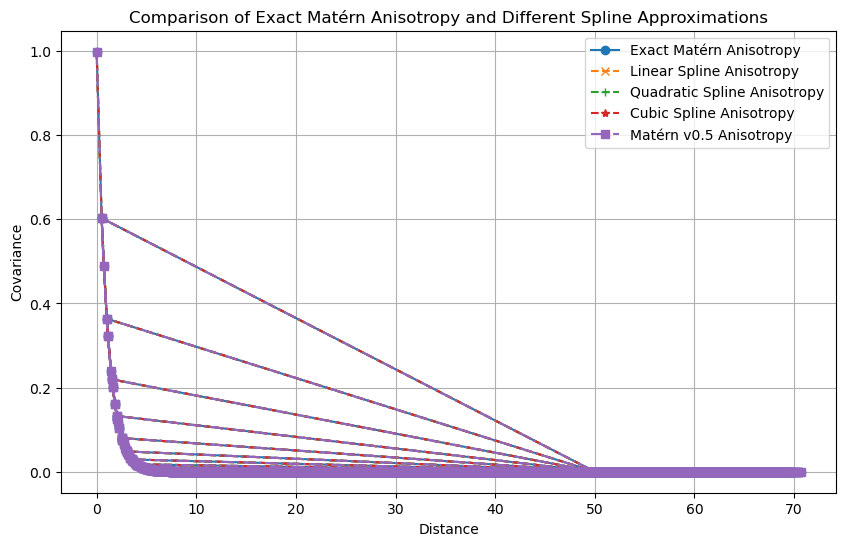

Mean distance between exact and linear spline anisotropy approximation: 5.098771071581819e-08
Mean distance between exact and quadratic spline anisotropy approximation: 1.1204197251225957e-10
Mean distance between exact and cubic spline anisotropy approximation: 1.1580159313400262e-12
Mean distance between exact and Matérn v0.5 anisotropy approximation: 2.1141082266830937e-19


In [39]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.special import kv, gamma
import matplotlib.pyplot as plt

def exact_matern_cov_anisotropy(params, distances):
    sigmasq, range_lat, range_lon, smooth = params
    matern_values = sigmasq * (2**(1 - smooth)) / gamma(smooth) * (distances / np.sqrt(range_lat**2 + range_lon**2))**smooth * kv(smooth, distances / np.sqrt(range_lat**2 + range_lon**2))
    
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)

    out = np.zeros_like(distances)
    non_zero_indices = distances != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = (sigmasq * (2**(1-smooth)) / gamma(smooth) *
                                (distances[non_zero_indices])**smooth *
                                kv(smooth, distances[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    return out

def spline_matern_cov_anisotropy(params, distances, k=3, coarse_factor=4):
    sigmasq, range_lat, range_lon, smooth = params
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    # Flatten the 2D distance matrix for fitting
    flat_distances = distances.flatten()
    
    # Fit spline to Matérn covariance function on coarse distances
    fit_distances = np.linspace(epsilon, np.max(flat_distances), len(flat_distances) // coarse_factor)
    exact_values = exact_matern_cov_anisotropy(params, fit_distances)
    spline_params = splrep(fit_distances, exact_values, k=k)
    
    # Evaluate spline at dense distances
    spline_values = splev(flat_distances, spline_params)
    
    # Reshape the spline values back to the original 2D shape
    spline_values = spline_values.reshape(distances.shape)
    return spline_values

def matern_cov_anisotropy_v05(params, distances):
    sigmasq, range_lat, range_lon, smooth = params
    
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    out = np.zeros_like(distances)
    
    non_zero_indices = distances != 0
    if np.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * np.exp(- (distances[non_zero_indices]))
    out[~non_zero_indices] = sigmasq
    
    return out

# Parameters
params = (1.0, 1.0, 1.0, 0.5)  # sigmasq, range_lat, range_lon, smooth

# Generate distances (2D matrix)
x = np.linspace(0.001, 50, 100)
y = np.linspace(0.001, 50, 100)
X, Y = np.meshgrid(x, y)
distances = np.sqrt(X**2 + Y**2)

# Compute exact Matérn covariance values with anisotropy
exact_values_anisotropy = exact_matern_cov_anisotropy(params, distances)

coarse_factor = 4

# Compute spline approximated Matérn covariance values with anisotropy for different types of splines
spline_values_linear_anisotropy = spline_matern_cov_anisotropy(params, distances, k=1, coarse_factor=coarse_factor)
spline_values_quadratic_anisotropy = spline_matern_cov_anisotropy(params, distances, k=2, coarse_factor=coarse_factor)
spline_values_cubic_anisotropy = spline_matern_cov_anisotropy(params, distances, k=3, coarse_factor=coarse_factor)

# Compute the new Matérn covariance values with anisotropy using the v0.5 method
matern_values_v05_anisotropy = matern_cov_anisotropy_v05(params, distances)

# Calculate mean distance between exact and each spline approximation
mean_distance_linear_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_linear_anisotropy))
mean_distance_quadratic_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_quadratic_anisotropy))
mean_distance_cubic_anisotropy = np.mean(np.abs(exact_values_anisotropy - spline_values_cubic_anisotropy))
mean_distance_v05_anisotropy = np.mean(np.abs(exact_values_anisotropy - matern_values_v05_anisotropy))

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(distances.flatten(), exact_values_anisotropy.flatten(), label='Exact Matérn Anisotropy', linestyle='-', marker='o')
plt.plot(distances.flatten(), spline_values_linear_anisotropy.flatten(), label='Linear Spline Anisotropy', linestyle='--', marker='x')
plt.plot(distances.flatten(), spline_values_quadratic_anisotropy.flatten(), label='Quadratic Spline Anisotropy', linestyle='--', marker='+')
plt.plot(distances.flatten(), spline_values_cubic_anisotropy.flatten(), label='Cubic Spline Anisotropy', linestyle='--', marker='*')
plt.plot(distances.flatten(), matern_values_v05_anisotropy.flatten(), label='Matérn v0.5 Anisotropy', linestyle='-.', marker='s')
plt.xlabel('Distance')
plt.ylabel('Covariance')
plt.title('Comparison of Exact Matérn Anisotropy and Different Spline Approximations')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean distance between exact and linear spline anisotropy approximation: {mean_distance_linear_anisotropy}")
print(f"Mean distance between exact and quadratic spline anisotropy approximation: {mean_distance_quadratic_anisotropy}")
print(f"Mean distance between exact and cubic spline anisotropy approximation: {mean_distance_cubic_anisotropy}")
print(f"Mean distance between exact and Matérn v0.5 anisotropy approximation: {mean_distance_v05_anisotropy}")



In [50]:
torch.linspace(0.001, 5,5)

tensor([1.0000e-03, 1.2508e+00, 2.5005e+00, 3.7502e+00, 5.0000e+00])